In [1]:
%matplotlib inline
%load_ext nb_black
import pandas as pd
import numpy as np
import random
import itertools

import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from scipy.io import loadmat, savemat
from scipy.stats import f_oneway
from IPython.core.debugger import set_trace

from sklearn.feature_selection import mutual_info_regression

"""
monkey1
59 sessions
7 variables：(2380, 96)- spike count matrix, (2380,), (1, 2380), (2380,), (1, 2380)-orientation, (1, 1), (1, 2380)

monkey2
71 sessions

"""


"""sample to make the two monkey has comparable data size"""


def sample_sessions(monkey_num, save=False):
    data = loadmat("monkey" + "1" + ".mat")["monkey" + "1"][0]
    result = []
    for i in data:
        mask = i[0][0][-1][0] == max(i[0][0][-1][0])
        result.append([i[0][0][0][mask], i[0][0][-3][0][mask].reshape(1, -1)])
    samples = [
        filter_data_sample(result[session_num])[0].shape[0]
        for session_num in range(len(result))
    ]

    "sample from normal distribution"
    while True:
        norm_samples = np.random.normal(
            loc=np.mean(samples), scale=np.std(samples), size=len(get_data(monkey_num))
        ).round(0)
        if (norm_samples < 0).sum() == 0:
            norm_samples.sort()
            break

    "sampling"
    data = loadmat("monkey" + monkey_num + ".mat")["monkey" + monkey_num][0]
    result = []
    for i in data:
        mask = i[0][0][-1][0] == max(i[0][0][-1][0])
        result.append([i[0][0][0][mask], i[0][0][-3][0][mask].reshape(1, -1)])
    sample_s = pd.DataFrame(
        [
            filter_data_sample(result[session_num])[0].shape[0]
            for session_num in range(len(result))
        ],
        columns=["data2_samples"],
    )
    result = (
        sample_s.sort_values(by="data2_samples")
        .assign(ideal_samples=norm_samples)
        .apply(lambda x: min(x.values), 1)
    )
    return result.sort_index()


def sample_from_one_session(session_data, sample_number, save=False):
    sort_nums = np.arange(session_data[0].shape[0])
    random.shuffle(sort_nums)
    if save:
        return [
            session_data[0][sort_nums[: int(sample_number)]],
            session_data[1][sort_nums[: int(sample_number)]],
            session_data[2][:, sort_nums[: int(sample_number)]],
            session_data[3][sort_nums[: int(sample_number)]],
            session_data[4][:, sort_nums[: int(sample_number)]],
            session_data[5],
            session_data[6][:, sort_nums[: int(sample_number)]],
        ]
    else:
        return [
            session_data[0][sort_nums[: int(sample_number)]],
            session_data[1][:, sort_nums[: int(sample_number)]],
        ]


def get_data(monkey_index, bz=3, if_sample=False, filter_neurons=False):
    """
    i: seesion index, 0-counts_matrix, -3 orientation
    """
    data = loadmat("monkey" + monkey_index + ".mat")["monkey" + monkey_index][0]
    result = []
    for i in data:
        mask = i[0][0][-1][0] == max(i[0][0][-1][0])
        result.append([i[0][0][0][mask], i[0][0][-3][0][mask].reshape(1, -1)])
    if if_sample:
        sample_numbers = sample_sessions(monkey_index)
        result = [
            sample_from_one_session(result[i], sample_numbers[i])
            for i in range(len(sample_numbers))
        ]
    if filter_neurons:
        result_final = []
        for session_num in range(len(result)):
            data_sample = filter_data_sample(result[session_num])  # select one session
            pvalues = f_oneway(*list(split_data(data_sample, bin_size=bz).values()))[1]
            result_final.append([data_sample[0][:, pvalues < 0.05], data_sample[1]])
        result = result_final
    return result


def get_data_save(monkey_index, bz=3, if_sample=False, filter_neurons=False):
    """
    i: seesion index, 0-counts_matrix, -3 orientation
    """
    data = loadmat("monkey" + monkey_index + ".mat")["monkey" + monkey_index][0]
    result = []
    for i in data:
        mask = i[0][0][-1][0] == max(i[0][0][-1][0])
        result.append(
            [
                i[0][0][0][mask],
                i[0][0][1][mask],
                i[0][0][2][:, mask],
                i[0][0][3][mask],
                i[0][0][-3][:, mask],
                i[0][0][-2],
                i[0][0][-1][:, mask],
            ]
        )
    if if_sample:
        sample_numbers = sample_sessions(monkey_index, save=True)
        result = [
            sample_from_one_session(result[i], sample_numbers[i], save=True)
            for i in range(len(sample_numbers))
        ]
    if filter_neurons:
        result_final = []
        for session_num in range(len(result)):
            data_sample = filter_data_sample(
                result[session_num], save=True
            )  # select one session
            f_params = [
                i[0]
                for i in split_data(data_sample, bin_size=bz, save=True).values()
                if len(i[0]) > 0
            ]
            pvalues = f_oneway(*f_params)[1]
            result_final.append(
                [
                    data_sample[0][:, pvalues < 0.05],
                    data_sample[1],
                    data_sample[2],
                    data_sample[3],
                    data_sample[4],
                    data_sample[5],
                    data_sample[6],
                ]
            )
        result = result_final
    return result


def split_data(data_sample, bin_size, limit=0, save=False):
    #     "Counts_matrix",
    #                             "orientation",
    #                             "stimulus_class",
    #                             "trial_num",
    #                             "selected_class",
    #                             "session_number",
    #                             "contrast"
    if save:
        orientation = data_sample[-3].ravel()
    else:
        orientation = data_sample[1].ravel()
    groups = pd.cut(
        pd.Series(orientation),
        range(
            np.floor(orientation.min()).astype(int) - 1,
            np.ceil(orientation.max()).astype(int) + bin_size,
            bin_size,
        ),
    )
    df = pd.concat(
        [
            pd.DataFrame(data_sample[0]),
            pd.Series(orientation).rename("orientation"),
            groups.rename("group"),
        ],
        1,
    )
    if save:
        df = pd.concat(
            [
                df,
                pd.Series(data_sample[1]).rename("stimulus_class"),
                pd.Series(data_sample[2].ravel()).rename("trial_num"),
                pd.Series(data_sample[3]).rename("selected_class"),
                pd.Series(list(data_sample[5][0]) * len(data_sample[1])).rename(
                    "session_number"
                ),
                pd.Series(data_sample[6].ravel()).rename("contrast"),
            ],
            1,
        )
    return dict(
        df.groupby("group")
        .apply(
            lambda x: [x.drop("group", 1).values[:, :]]
            #             + [
            #                 each.ravel()
            #                 for each in np.split(x.drop("group", 1).values[:, -6:], range(1, 6), 1)
            #             ]
            #             if x.shape[0] >= limit
            #             else np.nan
        )
        .dropna()
    )


def bootstrap_sample(x, size_per_time, exp_num=1, times=100):
    sample = [
        (np.random.choice(x, size_per_time) ** exp_num).mean() for _ in range(times)
    ]
    return [np.mean(sample), np.std(sample)]


def plot_ten_neurons(dfs, select_p, exp_num=1, legend_on=True):
    x = [i.mid for i in list(dfs.keys()) if dfs[i].shape[0] > 0]
    for idx in select_p:
        y, yerr = zip(
            *[
                bootstrap_sample(i[:, idx], i.shape[0], exp_num)
                for i in list(dfs.values())
            ]
        )
        if list(dfs.values())[0].shape[1] < 100:
            if exp_num > 1:
                plt.plot(x, y)
                plt.fill_between(
                    x,
                    np.array(y) + np.array(yerr),
                    np.array(y) - np.array(yerr),
                    alpha=0.2,
                    #                     capsize=3,
                    label=r"$<r^" + str(exp_num) + "_{" + str(idx + 1) + "}|s>$",
                )
            else:
                plt.plot(
                    x, y, label=r"$<r^" + str(exp_num) + "_{" + str(idx + 1) + "}|s>$",
                )
                plt.fill_between(
                    x,
                    np.array(y) + np.array(yerr),
                    np.array(y) - np.array(yerr),
                    alpha=0.2,
                    #                     capsize=3,
                    #                     label=r"$<r_{" + str(idx + 1) + "}|s>$",
                )
        else:
            triu_index = np.triu_indices(96)
            plt.plot(x, y)
            plt.fill_between(
                x,
                np.array(y) + np.array(yerr),
                np.array(y) - np.array(yerr),
                alpha=0.2,
                #                     capsize=3,
                label=r"$<r_{"
                + str(triu_index[0][idx] + 1)
                + "} r_{"
                + str(triu_index[1][idx] + 1)
                + "}|s>$",
            )
    if exp_num == 1 and legend_on == True:
        plt.legend(frameon=False, ncol=2)
    else:
        plt.legend().remove()
    plt.xlabel("orientation")


#     plt.ylabel("average stimulus")


def normalize_across_trial(m, get_first=False):
    if get_first:
        return m[0] - m[0].mean(0)
    else:
        return m - m.mean(0)


def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


def draw_ellipse(x, y, ax, label, color):
    nstd = 2
    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    sc = plt.scatter(x, y, label=label, s=3, c=color)
    ell = Ellipse(
        xy=(np.mean(x), np.mean(y)),
        width=w,
        height=h,
        angle=theta,
        #         color=sc.get_facecolors()[0].tolist(),
        color=color,
        linestyle="-",
    )

    ell.set_facecolor("none")
    xmax, ymax = ell.get_patch_transform().transform(ell.get_path().vertices).max(0)
    xmin, ymin = ell.get_patch_transform().transform(ell.get_path().vertices).min(0)
    ax.add_artist(ell)
    ax.axes.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.axes.yaxis.set_major_locator(plt.MaxNLocator(4))
    return xmin, ymin, xmax, ymax


def filter_data_sample(data_sample, save=False):
    if save:
        mask = np.array(
            [True if i >= 210 and i <= 330 else False for i in data_sample[-3][0]],
            dtype=bool,
        ) & np.array((data_sample[0] > 200).sum(1) == 0, dtype=bool)
        data_sample[0] = (data_sample[0][mask],)
        data_sample[1] = (data_sample[1][mask],)
        data_sample[2] = (data_sample[2][:, mask],)
        data_sample[3] = (data_sample[3][mask],)
        data_sample[-3] = (data_sample[-3][:, mask],)
        data_sample[-2] = (data_sample[-2],)
        data_sample[-1] = (data_sample[-1][:, mask],)
    else:
        mask = np.array(
            [True if i >= 210 and i <= 330 else False for i in data_sample[1][0]],
            dtype=bool,
        ) & np.array((data_sample[0] > 200).sum(1) == 0, dtype=bool)
        data_sample[0] = data_sample[0][mask, :]
        data_sample[1] = data_sample[1][:, mask]
    return data_sample


def get_index_list(pair_neuron_list):
    l = []
    for i in pair_neuron_list:
        ref_df = pd.DataFrame(np.concatenate(np.triu_indices(96)).reshape(2, -1)).T
        l.append(ref_df[(ref_df[0] == i[0]) & (ref_df[1] == i[1])].index[0])
    return l


def sensivity(x, y):
    return (x.mean(0) - y.mean(0)) / np.where(
        ((np.var(x, 0) + np.var(y, 0)) / 2) ** 0.5 == 0,
        np.nan,
        ((np.var(x, 0) + np.var(y, 0)) / 2) ** 0.5,
    )


"""
calculate sensitivity
"""


def all_sensitivity(data, savename, monkey_num, bz=3, cate="linear"):
    sens_total = []
    for d in data:
        data_sample = filter_data_sample(d)
        dfs = split_data(data_sample, bin_size=bz)
        if cate in ["cross", "square"]:
            norm_dfs = [normalize_across_trial(i) for i in list(dfs.values())]
            r_ij = np.expand_dims(np.concatenate(norm_dfs), 2) * np.expand_dims(
                np.concatenate(norm_dfs), 1
            )
            if cate == "cross":
                sep_index = np.triu_indices(96, k=1)
            else:
                sep_index = np.diag_indices(96)
            r_ij_flat = np.vstack([r_ij[i][sep_index] for i in range(r_ij.shape[0])])
            data_sample = filter_data_sample([r_ij_flat, data_sample[1]])
            dfs = split_data(data_sample, bin_size=bz)
        value_list = list(dfs.values())

        sens_total.extend(
            np.concatenate(
                [
                    sensivity(value_list[i + 1], value_list[i])
                    for i in range(len(dfs) - 1)
                    if value_list[i].shape[0] >= 10 and value_list[i + 1].shape[0] >= 10
                ]
            )
        )

    pd.Series(sens_total).hist(bins=np.linspace(-2, 2, 100))

    plt.title("monkey " + monkey_num + " all sessions, " + str(cate))
    plt.grid(False)
    plt.savefig(savename + "_filter.pdf")


def single_sensitivity(data, session_num, savename, bz=3, cate="linear", save=True):
    sens_total = []
    data_sample = filter_data_sample(data[session_num])
    dfs = split_data(data_sample, bin_size=bz)
    if cate in ["cross", "square"]:
        norm_dfs = [normalize_across_trial(i) for i in list(dfs.values())]
        r_ij = np.expand_dims(np.concatenate(norm_dfs), 2) * np.expand_dims(
            np.concatenate(norm_dfs), 1
        )
        if cate == "cross":
            sep_index = np.triu_indices(96, k=1)
        else:
            sep_index = np.diag_indices(96)
        r_ij_flat = np.vstack([r_ij[i][sep_index] for i in range(r_ij.shape[0])])
        data_sample = filter_data_sample([r_ij_flat, data_sample[1]])
        dfs = split_data(data_sample, bin_size=bz)
    value_list = list(dfs.values())
    sens_total.extend(
        [
            [
                sensivity(value_list[i + 1], value_list[i]),
                list(dfs.keys())[i].mid,
                list(dfs.keys())[i + 1].mid,
            ]
            for i in range(len(dfs) - 1)
            if value_list[i].shape[0] >= 10 and value_list[i + 1].shape[0] >= 10
        ]
    )
    edge = int((len(sens_total) - 4) // 2)
    for s in sens_total[edge : edge + 4]:
        pd.Series(s[0]).hist(
            bins=np.linspace(-1, 1, 50),
            alpha=0.7,
            label="orientation " + str(s[1]) + " " + str(s[2]),
        )
    plt.legend()
    plt.title(
        "monkey "
        + str(monkey_num)
        + ", session: "
        + str(session_num)
        + ", bin size: "
        + str(bz)
        + ", "
        + str(cate)
    )
    plt.grid(False)
    if save:
        plt.savefig(savename + "_filter.pdf")


def change_dtypes(aa):
    revise_dtypes = {
        "Counts_matrix": "uint8",
        "orientation": "double",
        "stimulus_class": "<U1",
        "trial_num": "uint16",
        "selected_class": "<U1",
        "session_number": "int",
        "contrast": "double",
    }
    for key, item in aa.items():
        if key == "session_number":
            aa[key] = item[0]
        elif key in ["trial_num", "contrast", "orientation"]:
            aa[key] = item.reshape(1, -1).astype(revise_dtypes[key])
        else:
            aa[key] = item.astype(revise_dtypes[key])
    return aa


params = {
    "legend.fontsize": 14,
    "legend.frameon": False,
    "ytick.labelsize": 14,
    "xtick.labelsize": 14,
    "figure.dpi": 300,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "pdf.fonttype": 42,
    "font.sans-serif": "Myriad Pro",
    "font.family": "sans-serif",
}
plt.rcParams.update(params)


monkey_num = "2"
bz = 3  # bin size is 3
session_num = 20

<IPython.core.display.Javascript object>

In [7]:
sample_limit = 5
filter_neurons = False
data = get_data(monkey_num, if_sample=False, filter_neurons=filter_neurons)
data_sample = filter_data_sample(data[session_num])  # select one session
dfs = split_data(data_sample, bin_size=bz)  # split stimulus data (r) based on bin size
dfs = {k: dfs[k][0] for k in dfs.keys()}
norm_dfs = [
    normalize_across_trial(i)
    for i in list(dfs.values())
    if normalize_across_trial(i).shape[0] >= sample_limit
]
unnorm_dfs = [i for i in list(dfs.values()) if i.shape[0] >= sample_limit]

key_list = [k for k in list(dfs.keys()) if dfs[k].shape[0] >= sample_limit]

<IPython.core.display.Javascript object>

### Figure S5 - A

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


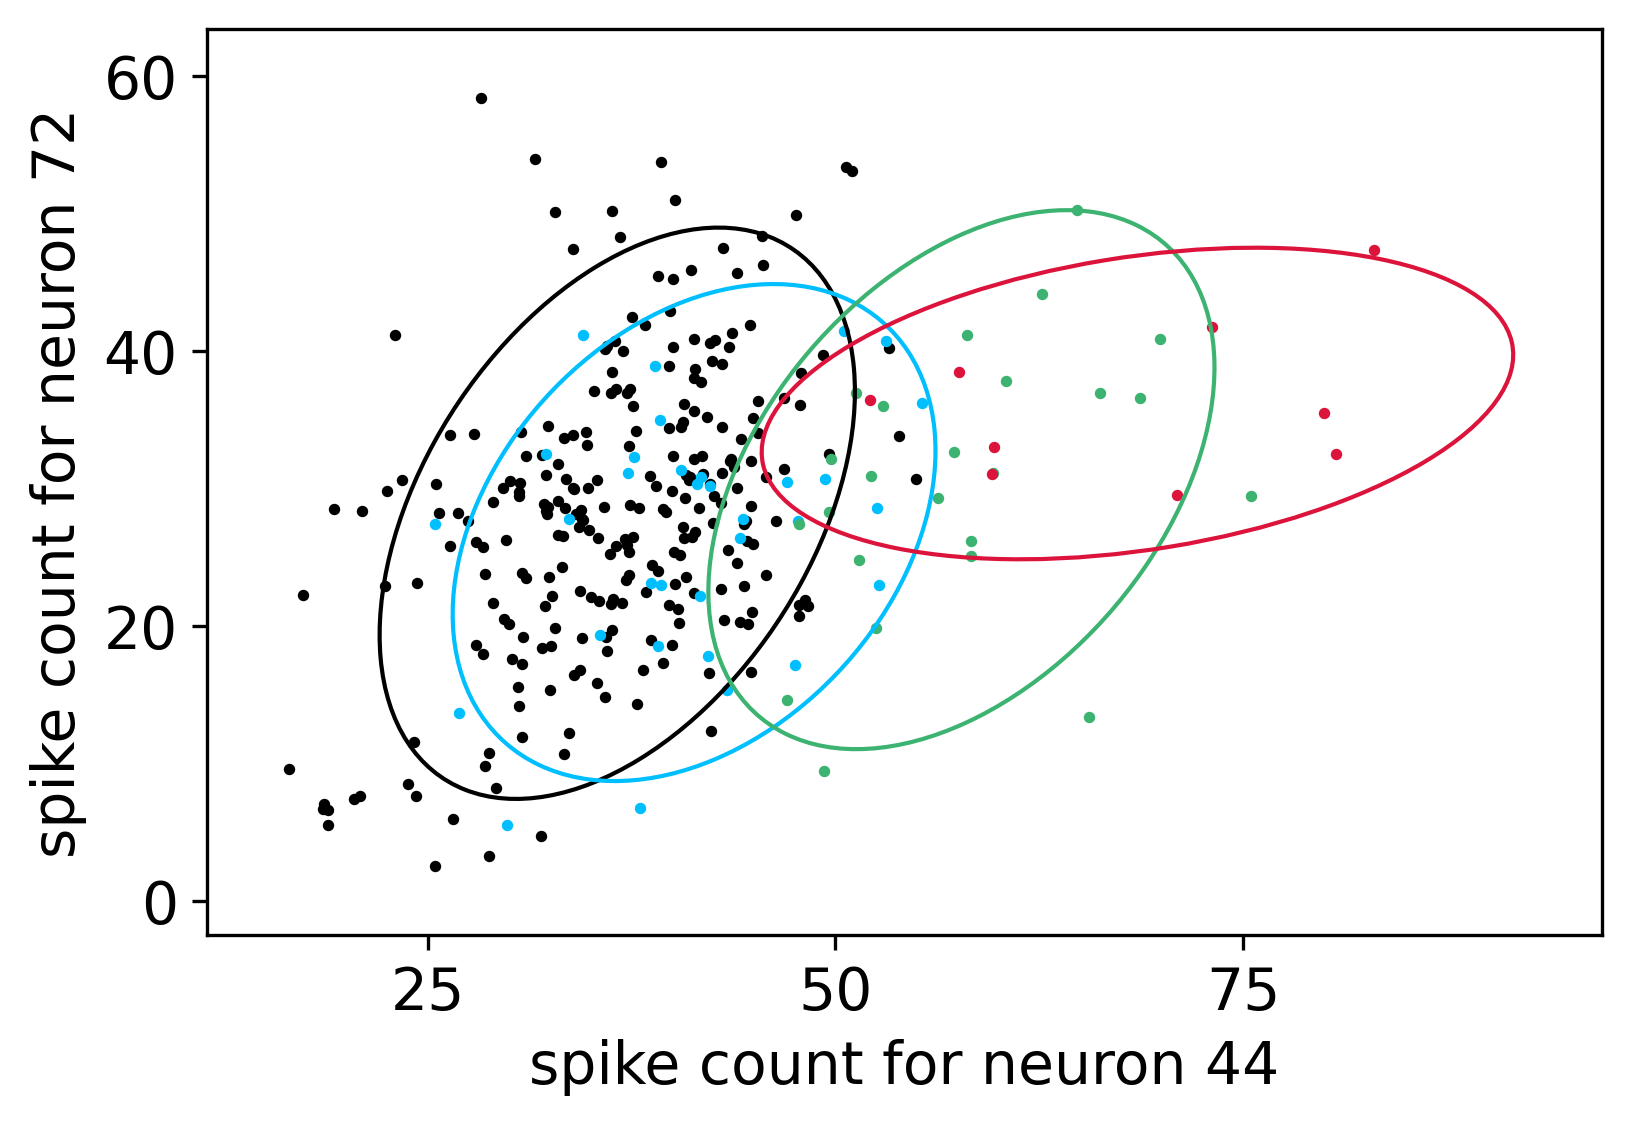

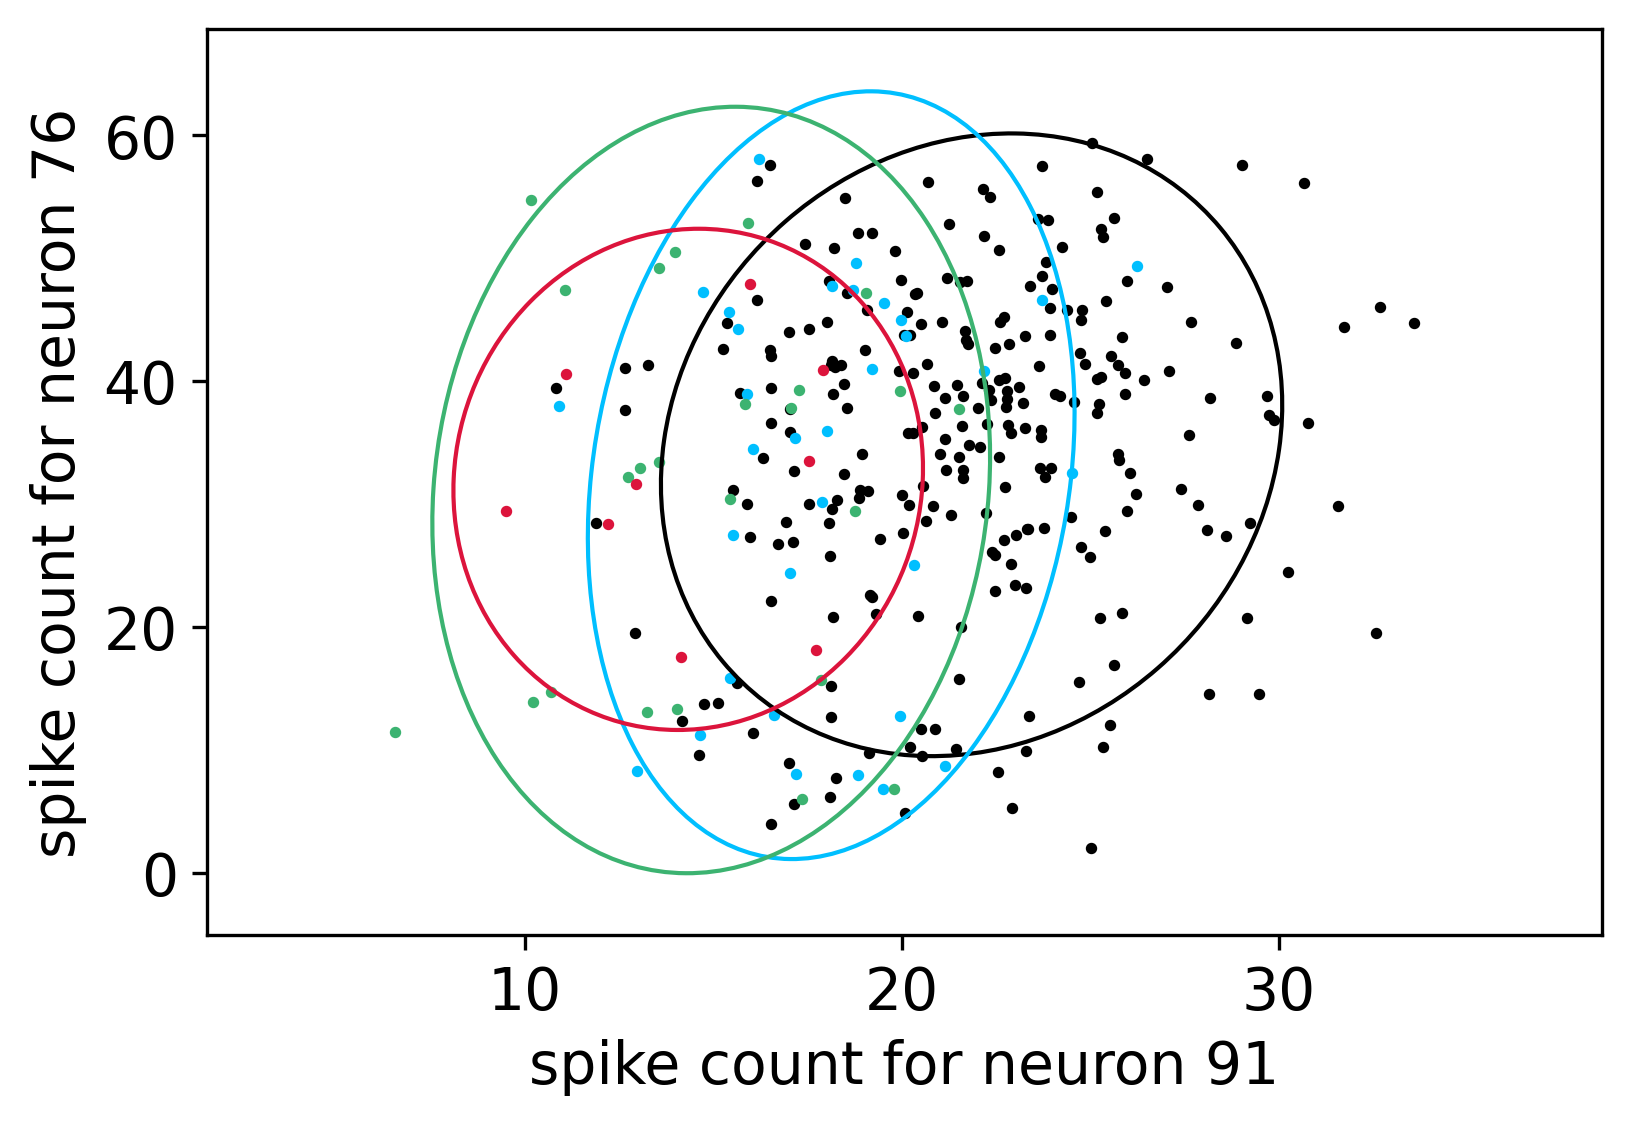

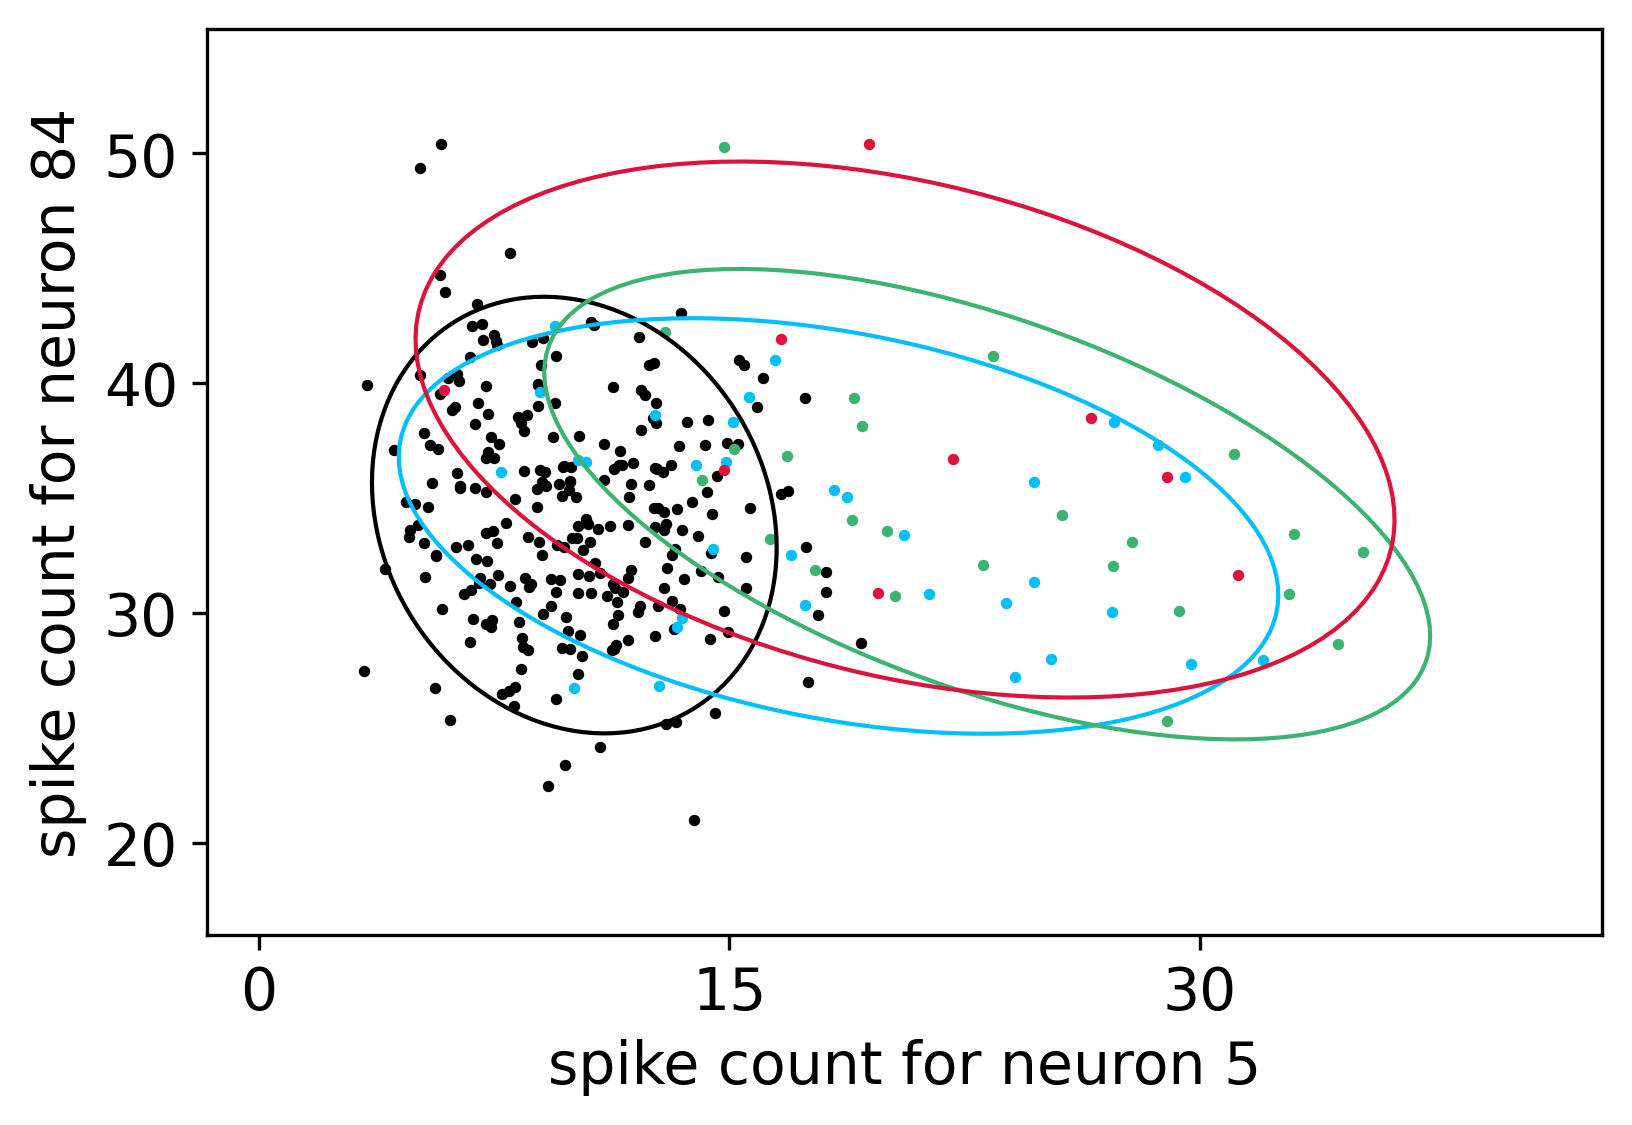

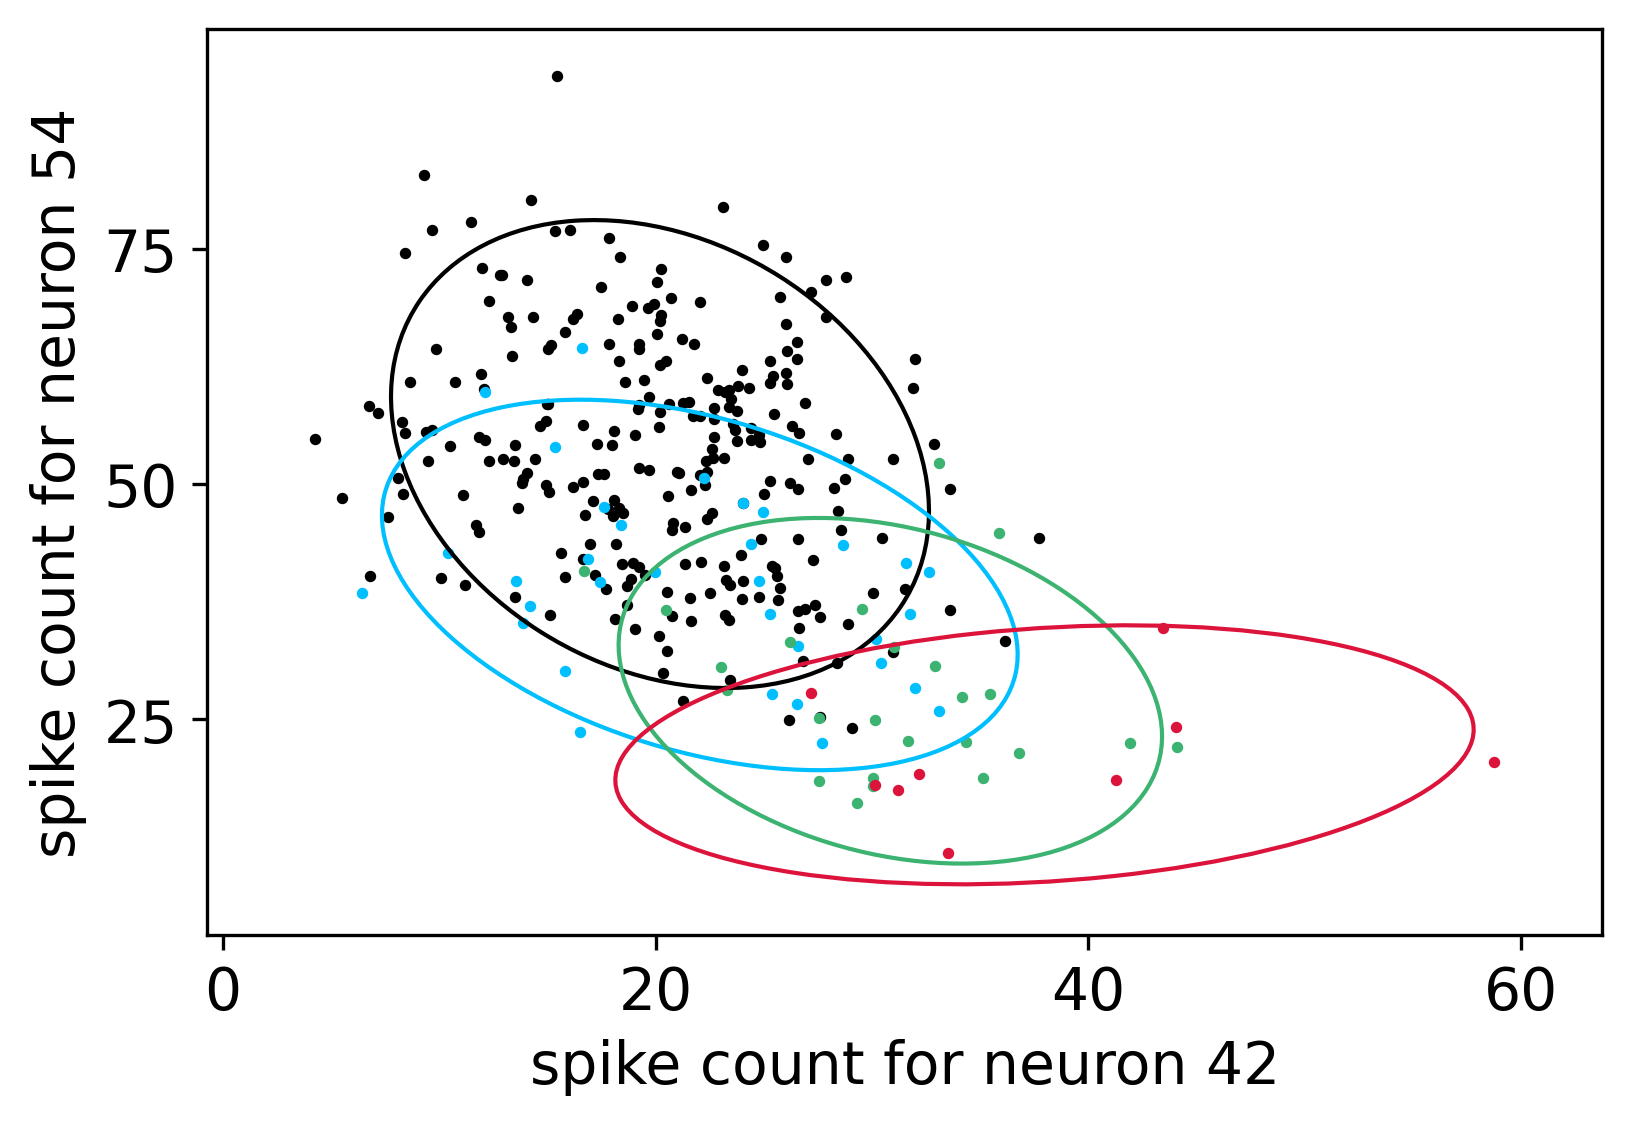

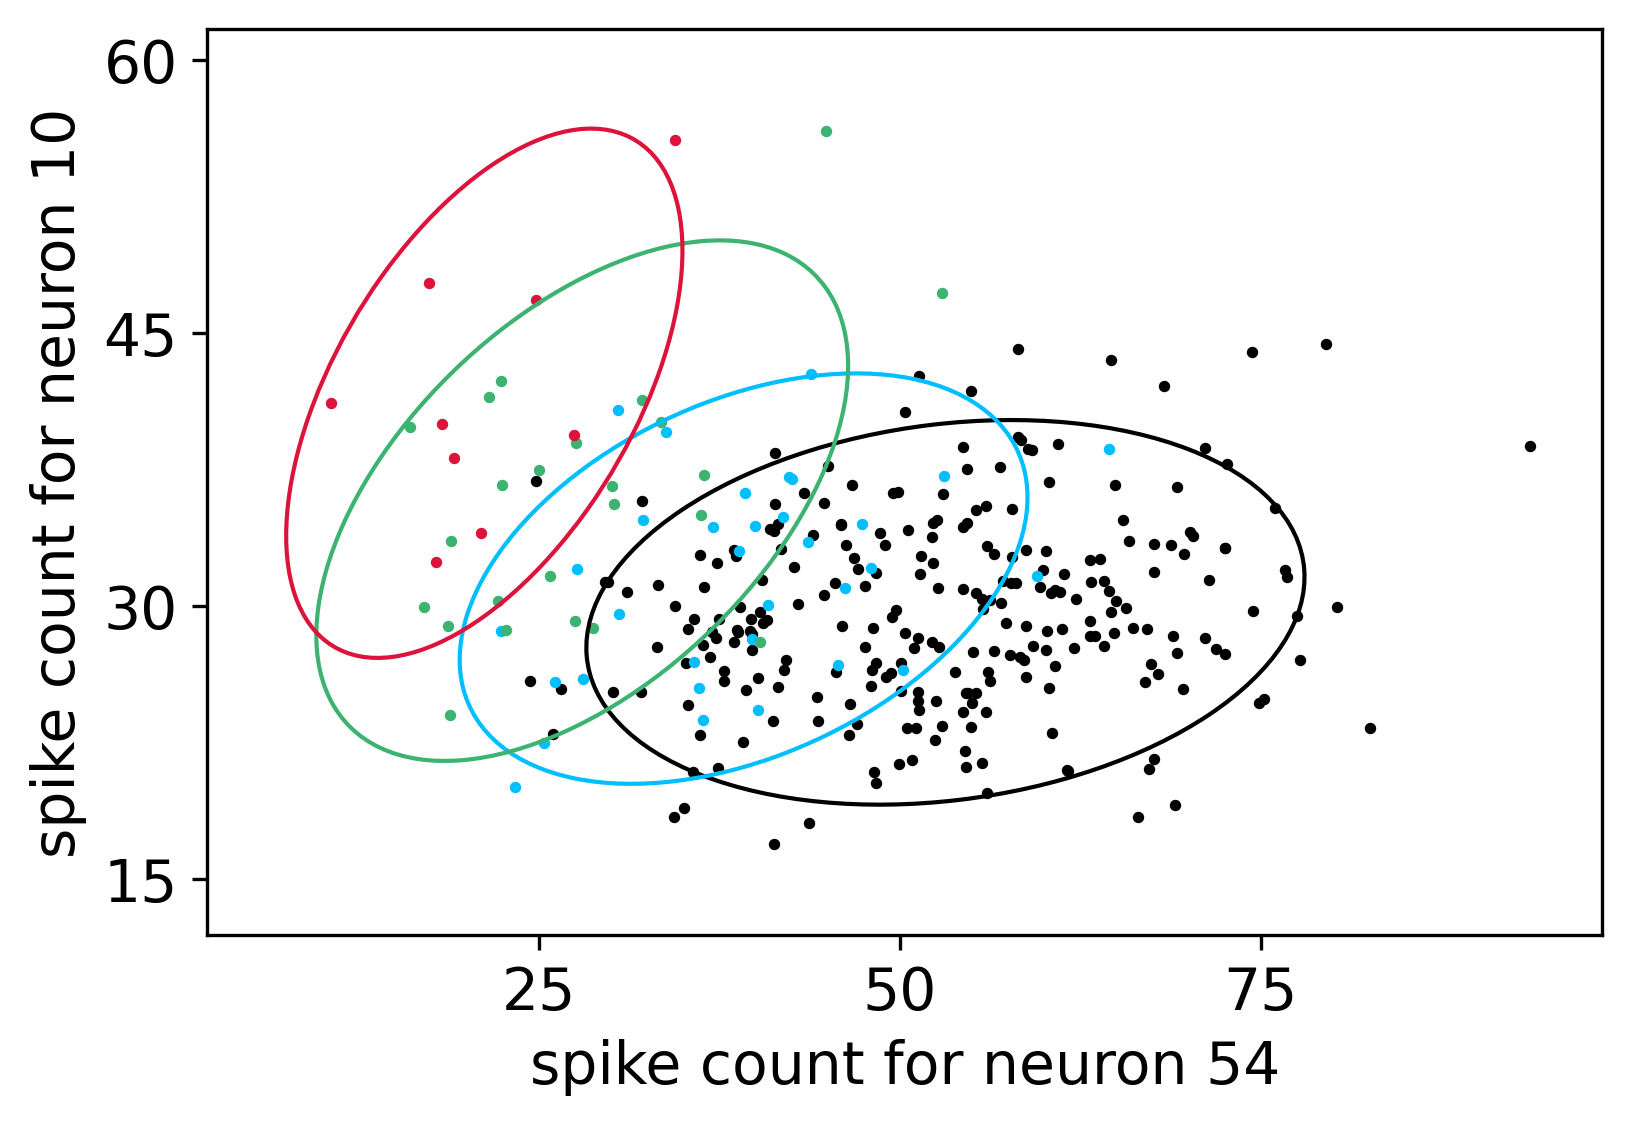

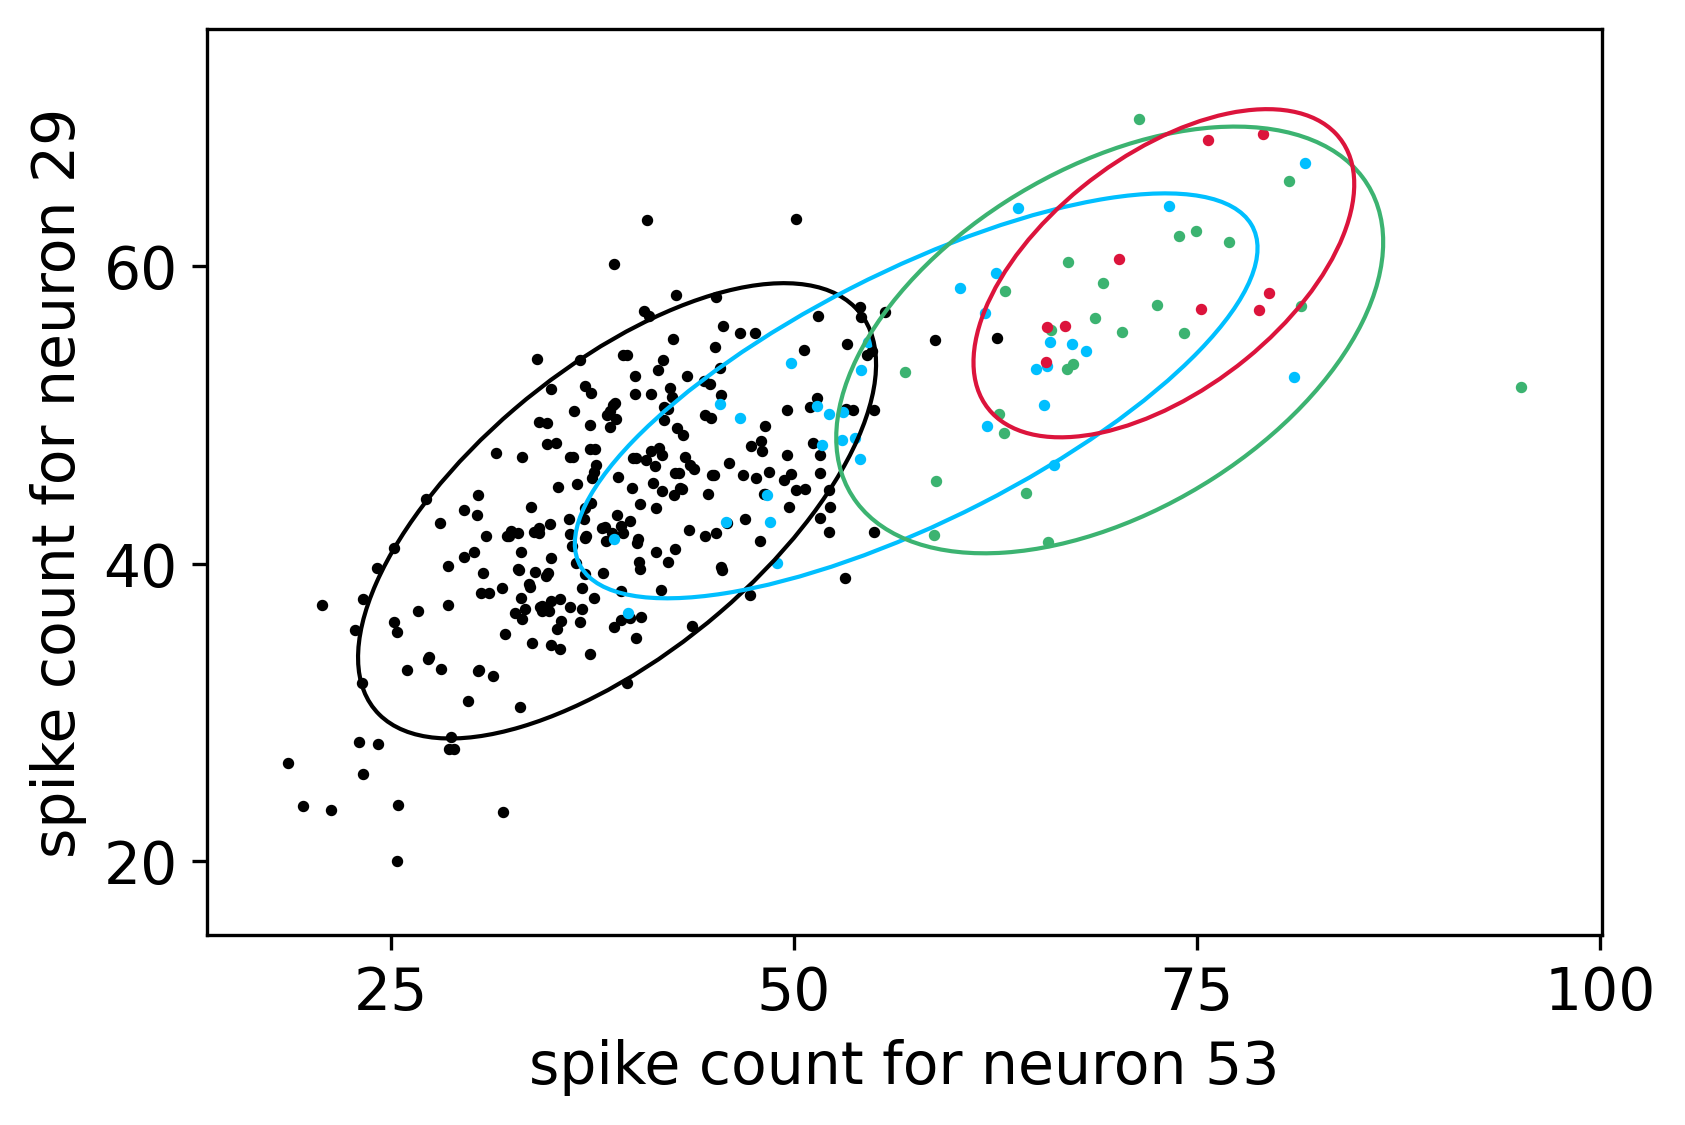

<IPython.core.display.Javascript object>

In [8]:
"""
select 2 bins (which are far away from each other, and have relatively large amount of data points)
"""
plt.rcParams["figure.dpi"] = 300

pick_two_bins = [11, 14, 17, 20]
sample_size = min([unnorm_dfs[i].shape[0] for i in list(pick_two_bins)])

"neurons without filter"
select_neuron_indexes_list = [[43, 71], [90, 75], [4, 83], [41, 53], [53, 9], [52, 28]]
"neurons with filter"
# select_neuron_indexes_list = [[39, 56], [15, 17], [43, 56], [49, 51], [30, 31]]
# select_neuron_indexes_list = [
#     np.random.choice(range(unnorm_dfs[0].shape[1]), 2).tolist()
# ]
color_list = ["black", "deepskyblue", "mediumseagreen", "crimson"]
if_sample = False

for select_neuron_indexes in select_neuron_indexes_list:
    fig, ax = plt.subplots()
    xmin_list, ymin_list, xmax_list, ymax_list = [], [], [], []
    for idx, i in enumerate(pick_two_bins):
        all_sample = unnorm_dfs[i][:, select_neuron_indexes]
        np.random.shuffle(all_sample)
        if if_sample:
            x, y = all_sample[:sample_size].T
        else:
            x, y = all_sample.T
        """add noise to discriminate dots"""
        x += np.random.rand(len(x))
        y += np.random.rand(len(y))
        xmin, ymin, xmax, ymax = draw_ellipse(
            x.tolist(),
            y.tolist(),
            ax,
            #             "orientation " + str(key_list[i]),
            "",
            color=color_list[idx],
        )
        xmin_list.append(min(min(x), xmin))
        xmax_list.append(max(max(x), xmax))
        ymin_list.append(min(min(y), ymin))
        ymax_list.append(max(max(y), ymax))

    plt.legend(frameon=False)
    plt.xlabel("spike count for neuron " + str(select_neuron_indexes[0] + 1))
    plt.ylabel("spike count for neuron " + str(select_neuron_indexes[1] + 1))
    plt.xlim(min(xmin_list) - 5, max(xmax_list) + 5)
    plt.ylim(min(ymin_list) - 5, max(ymax_list) + 5)
#     plt.savefig(
#         "rirj1_unnorm"
#         + str(select_neuron_indexes)
#         + "_"
#         + str(if_sample)
#         + "_filter.pdf"
#     )

### Figure S5 - B Linear and Square

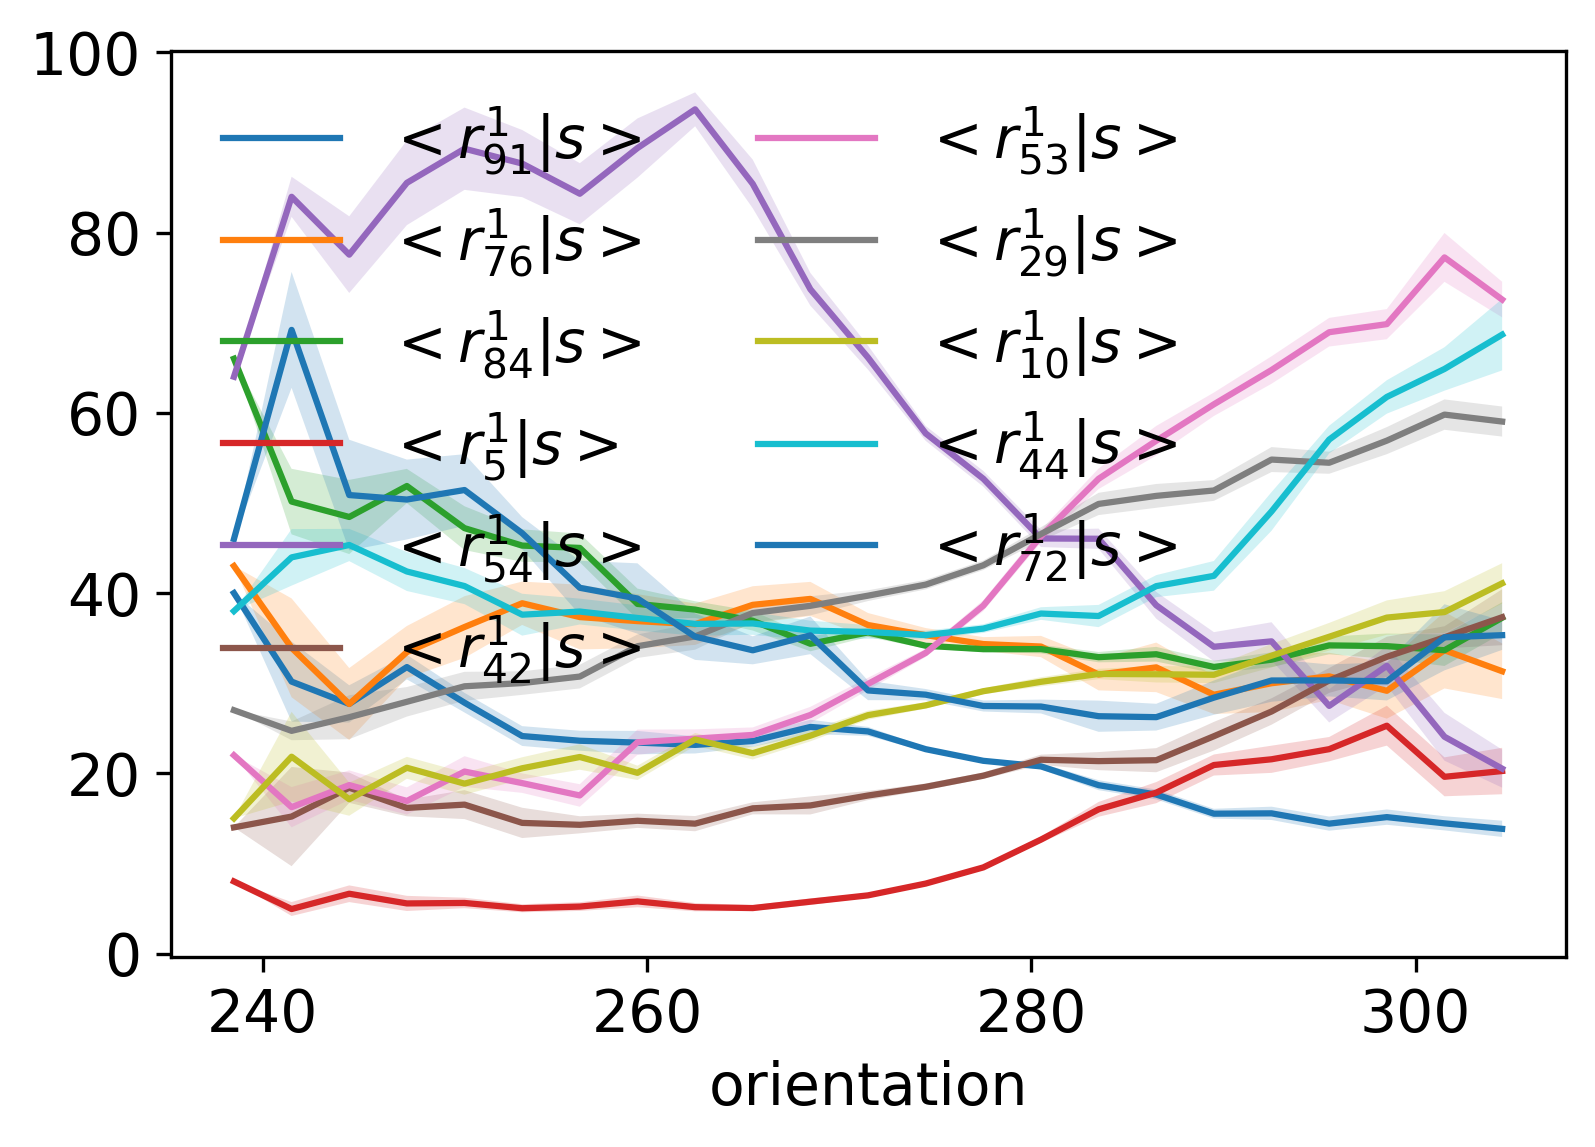

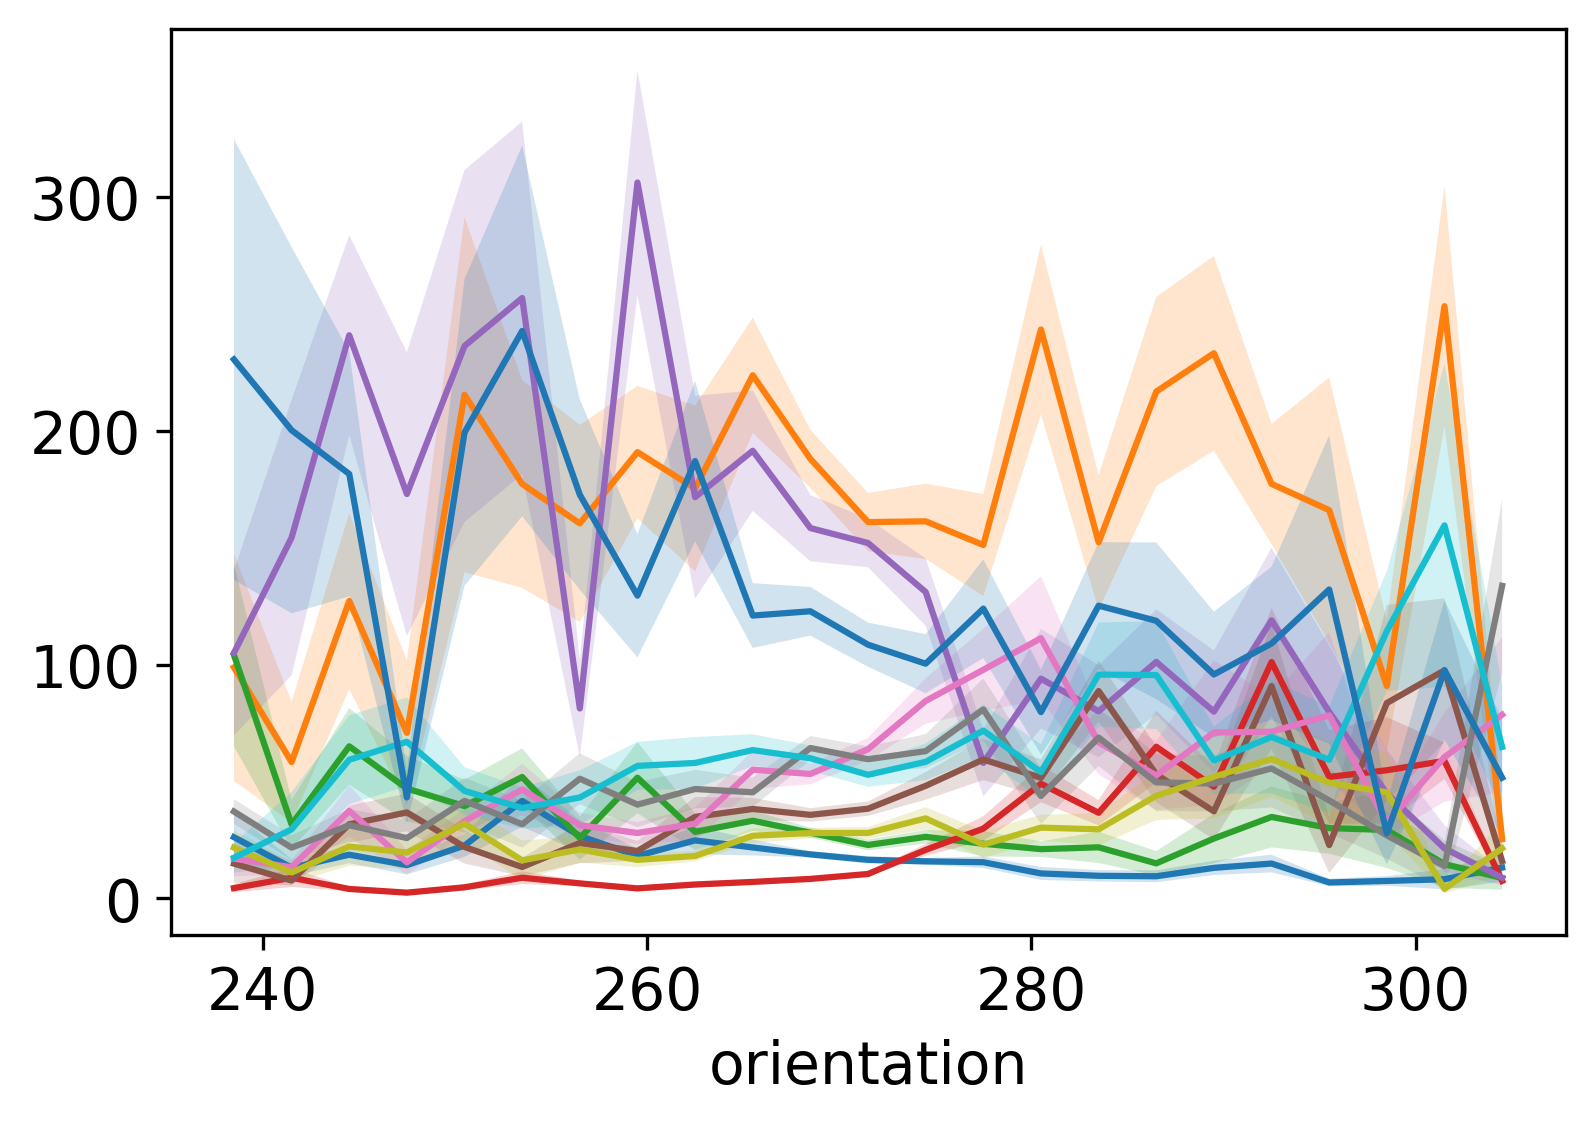

<IPython.core.display.Javascript object>

In [4]:
"""
plot 10 neurons: xlabel is the median of the bin, 
ylabel is the average stimulus (r) for the neuron across trials in that bin
"""
plt.rcParams["figure.dpi"] = 300

# pvalues = f_oneway(*list(dfs.values()))[
#     1
# ]  # calculate p-values for 96 neurons (linear mode)
# select_p = (
#     pd.Series(pvalues).sort_values().index[:5]
# )  # select neurons with smallest 10 p-values
select_p = [90, 75, 83, 4, 53, 41, 52, 28, 9, 43, 71]
plot_ten_neurons(dict(zip(key_list, list(dfs.values()))), select_p, exp_num=1)
# plt.savefig("LinearTuning_filter_" + str(filter_neurons) + ".pdf")

plt.figure()
# pvalues = f_oneway(*[i ** 2 for i in norm_dfs])[
#     1
# ]  # calculate p-values for 96 neurons (square mode)
# select_p = (
#     pd.Series(pvalues).sort_values().index[:5]
# )  # select neurons with smallest 10 p-values
plot_ten_neurons(dict(zip(key_list, norm_dfs)), select_p, exp_num=2)
# plt.savefig("SquareTuning_filter_" + str(filter_neurons) + ".pdf")

### Figure S5 - B Cross

/home/qlyang/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '
/home/tyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice.
/home/qlyang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


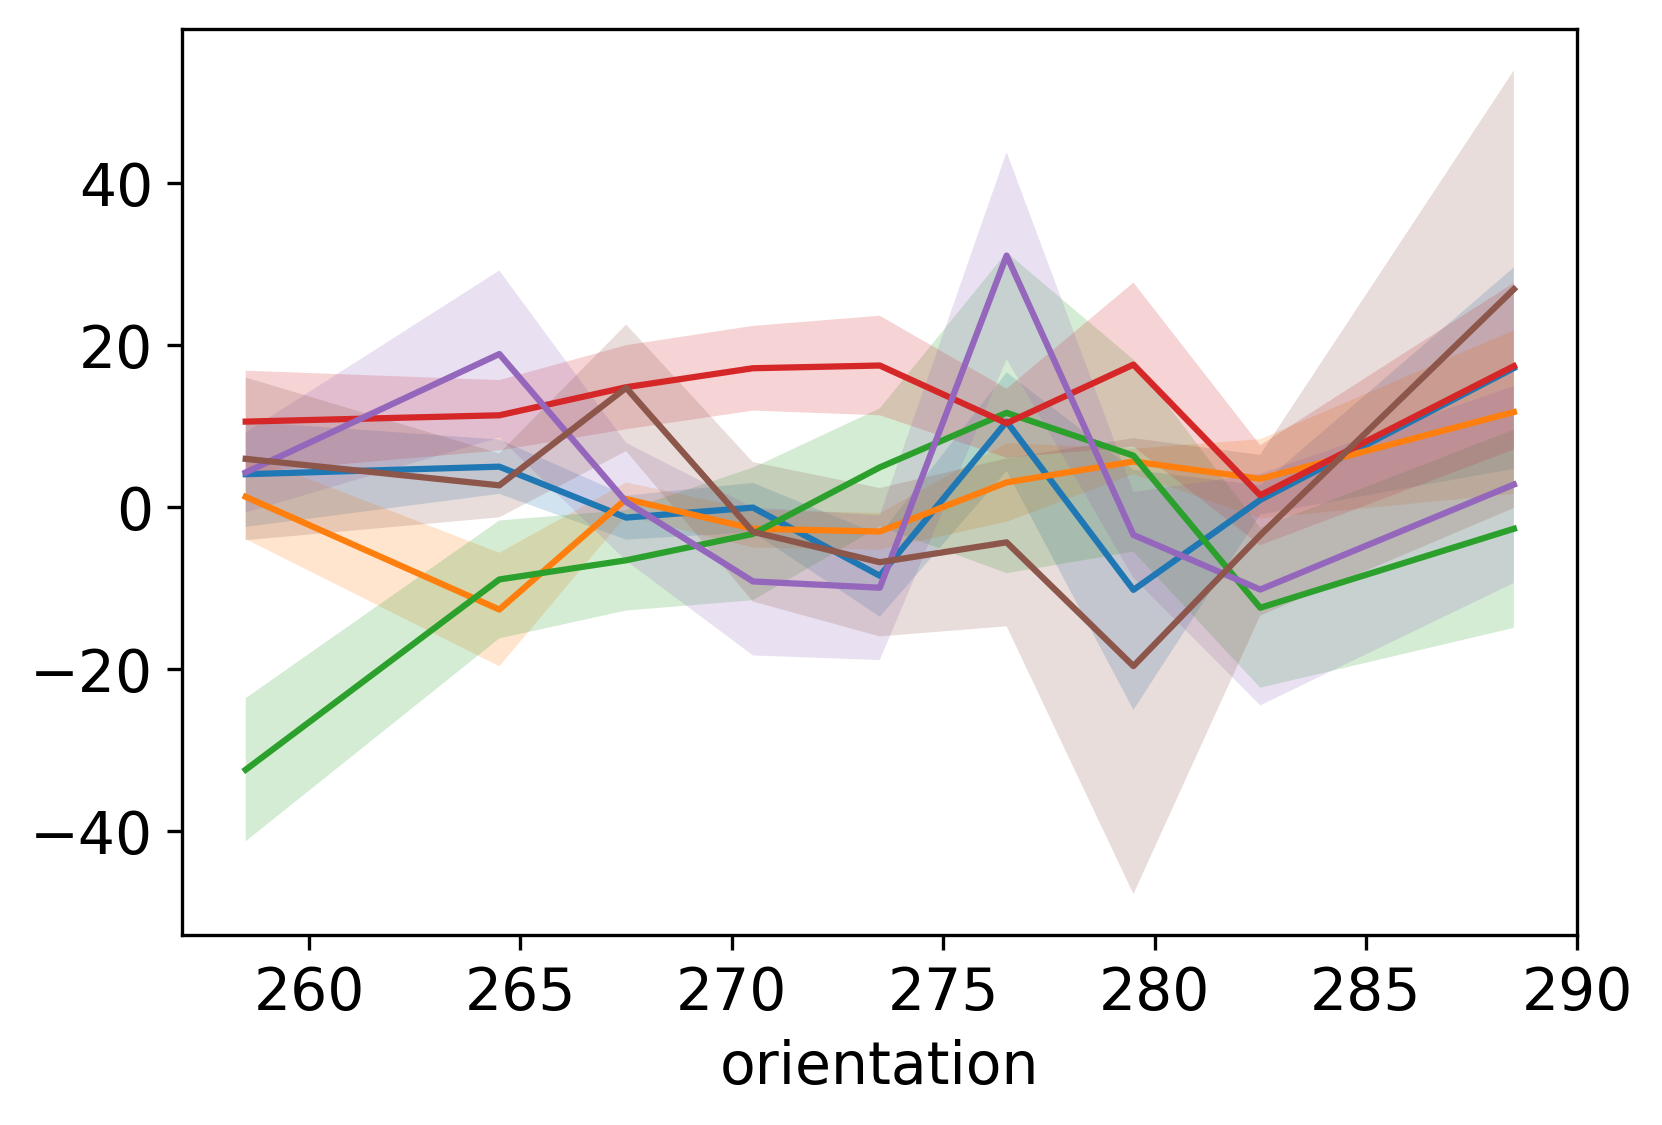

<IPython.core.display.Javascript object>

In [5]:
sample_limit = 0
filter_neurons = False
data = get_data(monkey_num, if_sample=False, filter_neurons=filter_neurons)
data_sample = filter_data_sample(data[session_num])  # select one session
dfs = split_data(data_sample, bin_size=bz)  # split stimulus data (r) based on bin size
dfs = {k: dfs[k][0] for k in dfs.keys()}

norm_dfs = [
    normalize_across_trial(i)
    for i in list(dfs.values())
    if normalize_across_trial(i).shape[0] >= sample_limit
]

r_ij = np.expand_dims(np.concatenate(norm_dfs), 2) * np.expand_dims(
    np.concatenate(norm_dfs), 1
)

r_ij_flat = np.concatenate(
    [r_ij[i][np.triu_indices(96)] for i in range(r_ij.shape[0])]
).reshape(r_ij.shape[0], -1)

"""
construct data_sample_qu similar to data_sample
"""
data_sample_qu = filter_data_sample([r_ij_flat, data_sample[1]])

"""calculate p-values for 4656 (96*97/2) neurons (quadratic)"""
dfs_qu = split_data(data_sample_qu, bin_size=bz)
dfs_qu = {k: dfs_qu[k][0] for k in dfs_qu.keys()}
pvalues = f_oneway(*list(dfs_qu.values()))[1]

x, y = np.triu_indices(96)

tg = pd.DataFrame(
    [
        x,
        y,
        np.array([i.mean(0) for i in list(dfs_qu.values())]).var(0) ** (0.5)
        #         / np.array([i.mean(0) for i in list(dfs_qu.values())]).mean(0),
    ],
    index=["x", "y", "coeff of var"],
).T.sort_values(by="coeff of var")
# remove square lines
tg = tg[tg.x != tg.y][["x", "y"]].values[-5:]

"""select neurons with smallest 10 p-values"""
# select_p = pd.Series(pvalues).sort_values().sample(5).index
select_p = get_index_list([[75, 90], [4, 83], [41, 53], [28, 52], [9, 53], [43, 71]])
# select_p = get_index_list(tg)
dfs_qu_clean = {key: val for key, val in dfs_qu.items() if val.shape[0] >= 5}
plot_ten_neurons(dfs_qu_clean, select_p, legend_on=False)
# plt.savefig("CorrelationTuning_filter_" + str(filter_neurons) + ".pdf")

### Figure S5 - C (save data)

In [ ]:
ref_data = get_data_save("1", if_sample=True, filter_neurons=True)
monkey1_mean, monkey1_std = (
    np.mean([r[0].shape[1] for r in ref_data]),
    np.std([r[0].shape[1] for r in ref_data]),
)

for monkey_num in ["1", "2"]:
    result = get_data_save(monkey_num, if_sample=True, filter_neurons=True)
    while True:
        select_neuron_samples = np.random.normal(
            monkey1_mean, monkey1_std, len(result)
        ).round()
        if (select_neuron_samples <= 0).sum() == 0:
            break
    select_neuron_samples.sort()

    select_neuron_samples_final = (
        pd.DataFrame([r[0].shape[1] for r in result], columns=["origin_sample"])
        .sort_values(by="origin_sample")
        .assign(ideal=select_neuron_samples)
        .apply(lambda x: min(x.values), 1)
        .sort_index()
    )

    for i in range(len(result)):
        result[i][0] = result[i][0][
            :,
            sorted(
                random.sample(
                    np.arange(result[i][0].shape[1]).tolist(),
                    int(select_neuron_samples_final[i]),
                )
            ),
        ]
    reformat_list = []
    for r in result:
        reformat_list.extend(
            [
                {
                    "Counts_matrix": j[:, :-6],
                    "orientation": j[:, -6],
                    "stimulus_class": j[:, -5],
                    "trial_num": j[:, -4],
                    "selected_class": j[:, -3],
                    "session_number": j[:, -2],
                    "contrast": j[:, -1],
                }
                for j in split_data(r, bin_size=bz, limit=5, save=True).values()
            ]
        )
    reformat_list = [change_dtypes(aa) for aa in reformat_list]
    savemat("monkey" + monkey_num + "_filter_new.mat", {"data": reformat_list})